In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/robi-datathon-2-pre-assessment/sample_submission.csv
/kaggle/input/robi-datathon-2-pre-assessment/train.csv
/kaggle/input/robi-datathon-2-pre-assessment/test.csv


In [2]:
import numpy as np
import pandas as pd
import os


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, accuracy_score,r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from keras import layers
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import lightgbm as lgb
import optuna

In [3]:
train_data= pd.read_csv('../input/robi-datathon-2-pre-assessment/train.csv')

test_data = pd.read_csv('../input/robi-datathon-2-pre-assessment/test.csv')

In [4]:
train_data.head()

,id,gender,s11,s12,s13,s16,s17,s18,s48,s52,...,n7,n8,n9,n10,n11,n12,n13,n14,n15,label
0,b'gAAAAABinOicS09vrmgh0_JyEHihI13ptO0rCyHP7l76...,M,Y,N,1,D,D,B,0,1,...,-9.126056,1.732291,3.698504,4.804517,1.544484,0,0,0.631220,5,0
1,b'gAAAAABinOiWGC1WhR6WYP0DA5ssGv9rIekrWUwCdJ8F...,M,Y,Y,1,D,D,B,1,1,...,-9.098287,1.505885,6.791357,6.110416,1.712354,0,0,0.392746,3,1
2,b'gAAAAABinOibTcOBFIVeA4nVF3FuFz_QX3ZlPPFc21gS...,M,Y,Y,1,D,D,B,0,1,...,-9.234894,1.503828,4.109685,3.953226,1.804260,0,0,0.222537,2,0
3,b'gAAAAABinOig-g3-Q1ggjlMhfUSdn21Aj5yVVeVvXbis...,F,Y,Y,1,D,D,B,0,1,...,-9.378025,1.485863,7.265876,4.559419,1.537645,0,0,0.154409,4,0
4,b'gAAAAABinOiXdoaNUzihOSbyY1tjWtd5EgMaXkkvH6SV...,M,N,Y,1,B,D,D,1,l,...,-9.261962,1.619210,3.737647,4.052003,1.637831,0,1,0.737560,1,0


In [5]:
print(train_data['label'].unique())

[0 1]


In [6]:
for col in train_data.columns:
    if train_data[col].dtypes == "object":
        print('Columns name: ', col)
        print(train_data[col].unique())

Columns name:  id
["b'gAAAAABinOicS09vrmgh0_JyEHihI13ptO0rCyHP7l76be71PWA2ReUc4HUQn16Fya1z8_VStNnFGaXJF262CgsuMPzOaknSeg=='"
 "b'gAAAAABinOiWGC1WhR6WYP0DA5ssGv9rIekrWUwCdJ8FvkVcSUl2AquMfWqtOqs3AQYGxS13wQv9Tx4GEkPEl5RnbchazqsZcw=='"
 "b'gAAAAABinOibTcOBFIVeA4nVF3FuFz_QX3ZlPPFc21gS9EYdw6Wo8Y5agbzfD6hhsaXZCBdrUQVPpZBXYsODc2PDjER2DX5QcA=='"
 ...
 "b'gAAAAABinOicscC37w1W9uiIlYL1U5D_mUtmgdUg8QTlgTDiCQj0N8l5xVuD5tTmGrYgogJLq-v9Z6fCyGeAng__ulkRJQi-Xg=='"
 "b'gAAAAABinOib-JZ8iQDxjSRsa1dPT1TqeSQ_si4mAw5fX_kDmvIAkIofJCd_35viYIE5AhMTE-MYsS5yYkiD_9J6ewDjL1cYuQ=='"
 "b'gAAAAABinOiZ3mCQAtoJFXj-Ymjhi9FbbZ_Ypi5gDoAEYe1Cx66GhkhZ5UIJNLcPlgrRyfpabvIwD5ok1GxipWfkujjwXyMMBw=='"]
Columns name:  gender
['M' 'F']
Columns name:  s11
['Y' 'N']
Columns name:  s12
['N' 'Y']
Columns name:  s16
['D' 'B' 'C' 'A']
Columns name:  s17
['D' 'C' 'B' 'A']
Columns name:  s18
['B' 'D' 'C' 'A']
Columns name:  s52
['1' 'l' '0' 'o']
Columns name:  s53
['  ' ' ']
Columns name:  s54
[nan 'b2' 'aa' '22' '2a' '2b' 'a2' 'bb' 'ab' 'b

In [7]:
test_data.head()

,id,gender,s11,s12,s13,s16,s17,s18,s48,s52,...,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15
0,b'gAAAAABinOi328DZcweGB4_nOyHA3Dy6o1YKYKyf3COx...,M,Y,Y,1,B,D,D,0,l,...,0.026301,-9.200175,2.122970,6.646617,4.801224,1.693087,0,0,0.439270,2
1,b'gAAAAABinOikutEIBjkUXl9lYTg4RI6jc4NfiMUCcVsn...,M,Y,Y,1,B,C,B,1,l,...,0.010774,-8.897092,1.770889,11.046294,6.407230,1.516728,0,0,0.084334,4
2,b'gAAAAABinOjBM70jBXOroAlUSq5lNXMd_oP0PU7jLQE5...,M,Y,N,1,B,D,B,1,l,...,0.016837,-9.173660,1.871872,2.805834,5.481219,1.788823,0,0,0.984210,0
3,b'gAAAAABinOimitAnqlgOcqnD_LeNL3WEbXNGvjd3QVPi...,M,Y,Y,1,D,D,B,0,1,...,0.015684,-9.178200,1.675028,6.354938,5.427266,1.792147,0,0,0.003492,1
4,b'gAAAAABinOi3W9p3Oka5MV_dc2TeorZUcIWOnnODSx7E...,M,Y,Y,1,D,C,B,1,1,...,0.006406,-8.726633,1.963535,6.810158,11.487845,1.880992,0,0,0.060614,0


In [8]:
def pre_data(data):
    col=['s53', 's54', 's55','s56', 's57', 's59']
    
    df= data.copy()
    # dropping columns
    df= df.drop(col, axis=1)
    #gender
    df['gender'].replace({'F':'0', 'M':'1'}, inplace=True)
    df['gender']= df['gender'].astype(int)
    #s11
    df['s11'].replace({'Y':'1', 'N':'0'}, inplace=True)
    df['s11']= df['s11'].astype(int)
    #s12
    df['s12'].replace({'Y':'1', 'N':'0'}, inplace=True)
    df['s12']= df['s12'].astype(int)
    
    #s16
    df['s16'].replace({'A':'0', 'B':'1', 'C':'2', 'D':'3'}, inplace=True)
    df['s16']= df['s16'].astype(int)
    
    #s17
    df['s17'].replace({'A':'0', 'B':'1', 'C':'2', 'D':'3'}, inplace=True)
    df['s17']= df['s17'].astype(int)
    
    #s18
    df['s18'].replace({'A':'0', 'B':'1', 'C':'2', 'D':'3'}, inplace=True)
    df['s18']= df['s18'].astype(int)
    
    #s52
    df['s52'].replace({'1':'1', 'l':'2', '0':'0', 'o':'3'}, inplace=True)
    df['s52']= df['s52'].astype(int)
    
    
    #s58
    df['s58'].replace({'B':'1', 'A':'0'}, inplace=True)
    df['s58']= df['s58'].astype(int)
    
    
    #s69
    df['s69'].replace({'x':'2', '~1':'1', 'C`':'3', '0':'0'}, inplace=True)
    df['s69']= df['s69'].astype(int)
    
    #s70
    df['s70'].replace({'op: D':'3', 'op: C':'2', 'op: B':'1', 'op: A':'0'}, inplace=True)
    df['s70']= df['s70'].astype(int)
    
    #s71
    df['s71'].replace({'a':'0', 'b':'1','c':'2', 'd':'3'}, inplace=True)
    df['s71']= df['s71'].astype(int)
    
    

    
    return df

In [9]:
train_df= pre_data(train_data)
train_df.head()

,id,gender,s11,s12,s13,s16,s17,s18,s48,s52,...,n7,n8,n9,n10,n11,n12,n13,n14,n15,label
0,b'gAAAAABinOicS09vrmgh0_JyEHihI13ptO0rCyHP7l76...,1,1,0,1,3,3,1,0,1,...,-9.126056,1.732291,3.698504,4.804517,1.544484,0,0,0.631220,5,0
1,b'gAAAAABinOiWGC1WhR6WYP0DA5ssGv9rIekrWUwCdJ8F...,1,1,1,1,3,3,1,1,1,...,-9.098287,1.505885,6.791357,6.110416,1.712354,0,0,0.392746,3,1
2,b'gAAAAABinOibTcOBFIVeA4nVF3FuFz_QX3ZlPPFc21gS...,1,1,1,1,3,3,1,0,1,...,-9.234894,1.503828,4.109685,3.953226,1.804260,0,0,0.222537,2,0
3,b'gAAAAABinOig-g3-Q1ggjlMhfUSdn21Aj5yVVeVvXbis...,0,1,1,1,3,3,1,0,1,...,-9.378025,1.485863,7.265876,4.559419,1.537645,0,0,0.154409,4,0
4,b'gAAAAABinOiXdoaNUzihOSbyY1tjWtd5EgMaXkkvH6SV...,1,0,1,1,1,3,3,1,2,...,-9.261962,1.619210,3.737647,4.052003,1.637831,0,1,0.737560,1,0


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28322 entries, 0 to 28321
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28322 non-null  object 
 1   gender  28322 non-null  int64  
 2   s11     28322 non-null  int64  
 3   s12     28322 non-null  int64  
 4   s13     28322 non-null  int64  
 5   s16     28322 non-null  int64  
 6   s17     28322 non-null  int64  
 7   s18     28322 non-null  int64  
 8   s48     28322 non-null  int64  
 9   s52     28322 non-null  int64  
 10  s58     28322 non-null  int64  
 11  s69     28322 non-null  int64  
 12  s70     28322 non-null  int64  
 13  s71     28322 non-null  int64  
 14  n1      28322 non-null  float64
 15  n2      28322 non-null  float64
 16  n3      28322 non-null  int64  
 17  n4      28322 non-null  float64
 18  n5      28322 non-null  float64
 19  n6      28322 non-null  float64
 20  n7      28322 non-null  float64
 21  n8      28322 non-null  float64
 22

<AxesSubplot:>

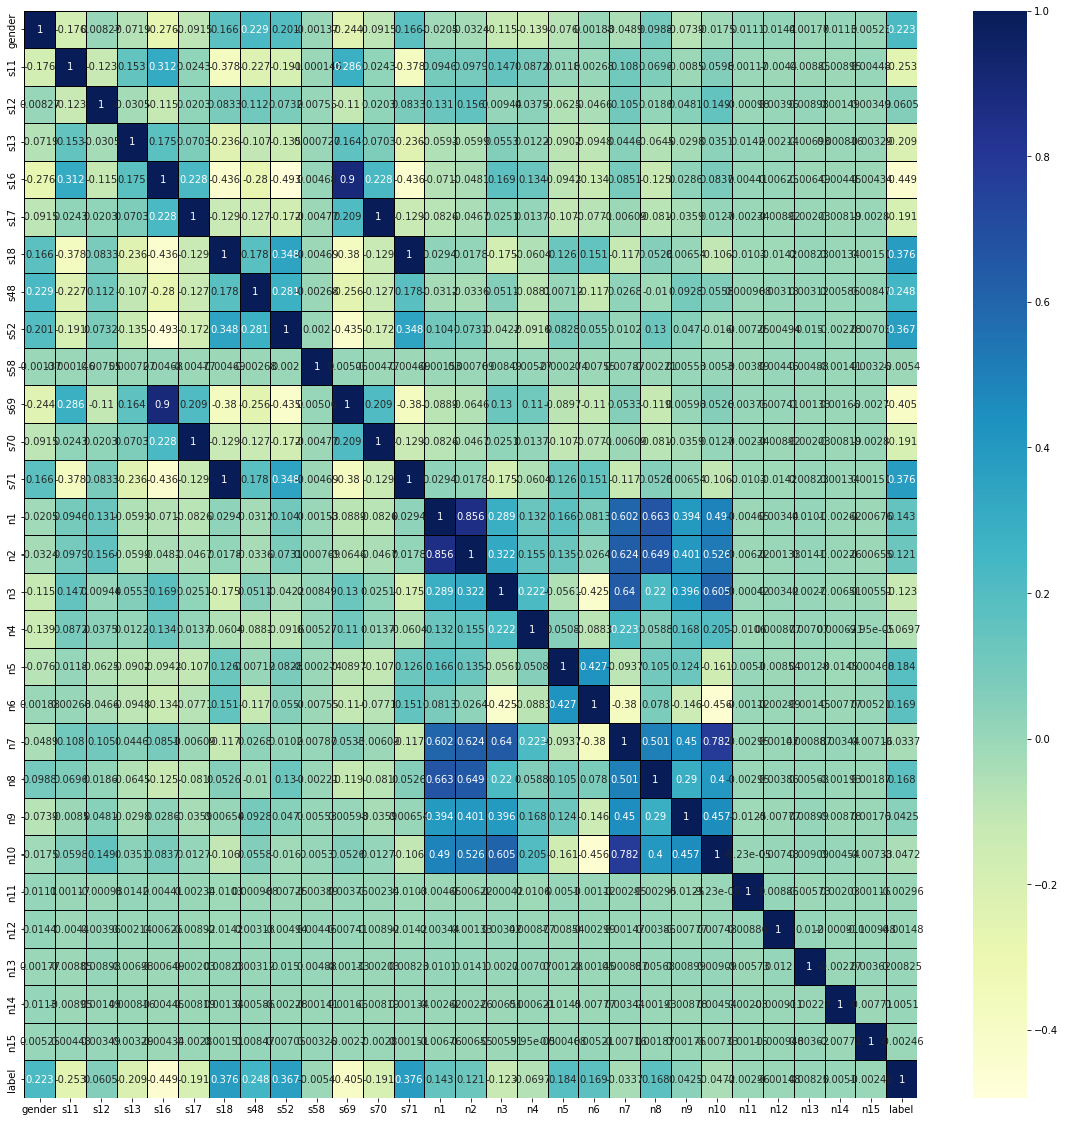

In [11]:
plt.figure(figsize=(20,20))
sns.heatmap(train_df.corr(), fmt='.3g', linecolor='black',linewidths=.5,cmap="YlGnBu" , annot=True)

In [12]:
test_df= pre_data(test_data)
test_df.head()

,id,gender,s11,s12,s13,s16,s17,s18,s48,s52,...,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15
0,b'gAAAAABinOi328DZcweGB4_nOyHA3Dy6o1YKYKyf3COx...,1,1,1,1,1,3,3,0,2,...,0.026301,-9.200175,2.122970,6.646617,4.801224,1.693087,0,0,0.439270,2
1,b'gAAAAABinOikutEIBjkUXl9lYTg4RI6jc4NfiMUCcVsn...,1,1,1,1,1,2,1,1,2,...,0.010774,-8.897092,1.770889,11.046294,6.407230,1.516728,0,0,0.084334,4
2,b'gAAAAABinOjBM70jBXOroAlUSq5lNXMd_oP0PU7jLQE5...,1,1,0,1,1,3,1,1,2,...,0.016837,-9.173660,1.871872,2.805834,5.481219,1.788823,0,0,0.984210,0
3,b'gAAAAABinOimitAnqlgOcqnD_LeNL3WEbXNGvjd3QVPi...,1,1,1,1,3,3,1,0,1,...,0.015684,-9.178200,1.675028,6.354938,5.427266,1.792147,0,0,0.003492,1
4,b'gAAAAABinOi3W9p3Oka5MV_dc2TeorZUcIWOnnODSx7E...,1,1,1,1,3,2,1,1,1,...,0.006406,-8.726633,1.963535,6.810158,11.487845,1.880992,0,0,0.060614,0


# **Data Normalization**

In [13]:
def normalize_data(data):
    df=  data.copy()
    scaler = MinMaxScaler()
    df = df.drop(['id'], axis=1)
    
    df['n1'] = scaler.fit_transform(df['n1'].values.reshape(-1,1))
    df['n2'] = scaler.fit_transform(df['n2'].values.reshape(-1,1))
    df['n3'] = scaler.fit_transform(df['n3'].values.reshape(-1,1))
    df['n4'] = scaler.fit_transform(df['n4'].values.reshape(-1,1))
    df['n5'] = scaler.fit_transform(df['n5'].values.reshape(-1,1))
    df['n6'] = scaler.fit_transform(df['n6'].values.reshape(-1,1))
    df['n7'] = scaler.fit_transform(df['n7'].values.reshape(-1,1))
    df['n8'] = scaler.fit_transform(df['n8'].values.reshape(-1,1))
    df['n9'] = scaler.fit_transform(df['n9'].values.reshape(-1,1))
    df['n10'] = scaler.fit_transform(df['n10'].values.reshape(-1,1))
    df['n11'] = scaler.fit_transform(df['n11'].values.reshape(-1,1))
    df['n12'] = scaler.fit_transform(df['n12'].values.reshape(-1,1))
    df['n13'] = scaler.fit_transform(df['n13'].values.reshape(-1,1))
    df['n14'] = scaler.fit_transform(df['n14'].values.reshape(-1,1))
    df['n15'] = scaler.fit_transform(df['n15'].values.reshape(-1,1))
    return df

train_norm = normalize_data(train_df)
train_norm.head()

,gender,s11,s12,s13,s16,s17,s18,s48,s52,s58,...,n7,n8,n9,n10,n11,n12,n13,n14,n15,label
0,1,1,0,1,3,3,1,0,1,1,...,0.420795,0.556536,0.136646,0.334484,0.111199,0.0,0.0,0.631190,0.833333,0
1,1,1,1,1,3,3,1,1,1,1,...,0.450609,0.329020,0.491901,0.454781,0.530885,0.0,0.0,0.392689,0.500000,1
2,1,1,1,1,3,3,1,0,1,1,...,0.303941,0.326953,0.183876,0.256065,0.760657,0.0,0.0,0.222461,0.333333,0
3,0,1,1,1,3,3,1,0,1,1,...,0.150269,0.308900,0.546406,0.311906,0.094102,0.0,0.0,0.154326,0.666667,0
4,1,0,1,1,1,3,3,1,2,1,...,0.274880,0.442900,0.141143,0.265165,0.344572,0.0,1.0,0.737541,0.166667,0


In [14]:
test_norm = normalize_data(test_df)
test_norm.head()


,gender,s11,s12,s13,s16,s17,s18,s48,s52,s58,...,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15
0,1,1,1,1,1,3,3,0,2,1,...,0.873321,0.338549,0.937691,0.478128,0.317720,0.482720,0.0,0.0,0.439274,0.333333
1,1,1,1,1,1,2,1,1,2,0,...,0.352395,0.662472,0.591598,0.974752,0.468311,0.041798,0.0,0.0,0.084332,0.666667
2,1,1,0,1,1,3,1,1,2,1,...,0.555821,0.366888,0.690863,0.044591,0.381481,0.722074,0.0,0.0,0.984220,0.000000
3,1,1,1,1,3,3,1,0,1,1,...,0.517138,0.362036,0.497367,0.445204,0.376422,0.730385,0.0,0.0,0.003489,0.166667
4,1,1,1,1,3,2,1,1,1,1,...,0.205848,0.844652,0.780967,0.496588,0.944704,0.952509,0.0,0.0,0.060612,0.000000


# **Split Data**

In [15]:
def split_valid_test_data(data, fraction=(1 -0.8)):
    df= data.copy()
    
    y= df['label']
    #lb = LabelBinarizer()
    
    #y = lb.fit_transform(y)
    
    x = df.drop(['label'], axis=1)
   
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.17, random_state=2018, stratify=y)
    
    return x_train, x_test, y_train, y_test
    


In [16]:
x_train,x_test,y_train, y_test = split_valid_test_data(train_norm)
print("train_x:{}".format(x_train.shape))
print("x_test:{}".format(x_test.shape))
print("train_y content:{}".format(y_train[:3]))

print("y_train:{}".format (y_train.shape))
print("y_test:{}".format(y_test.shape))

train_x:(23507, 28)
x_test:(4815, 28)
train_y content:25669    0
23779    0
104      1
Name: label, dtype: int64
y_train:(23507,)
y_test:(4815,)


In [17]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
test_norm = scaler.fit_transform(test_norm)


In [18]:
def model():
    inputs= layers.Input(shape=(x_train.shape[-1],))
    x= layers.Dense(512, activation='relu')(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    
    x = layers.Dense(128, activation="relu")(x)
    
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x= layers.Flatten()(x)
    
    preds= layers.Dense(1, activation='sigmoid', name='label')(x)
    
    model= keras.Model(inputs, outputs=[preds])
    
    return model
    

In [19]:
model = model( )
model.summary()

2022-06-10 12:19:13.519942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 12:19:13.524658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 12:19:13.525375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 12:19:13.526833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense (Dense)                (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896 

In [20]:
weights = model.get_weights()

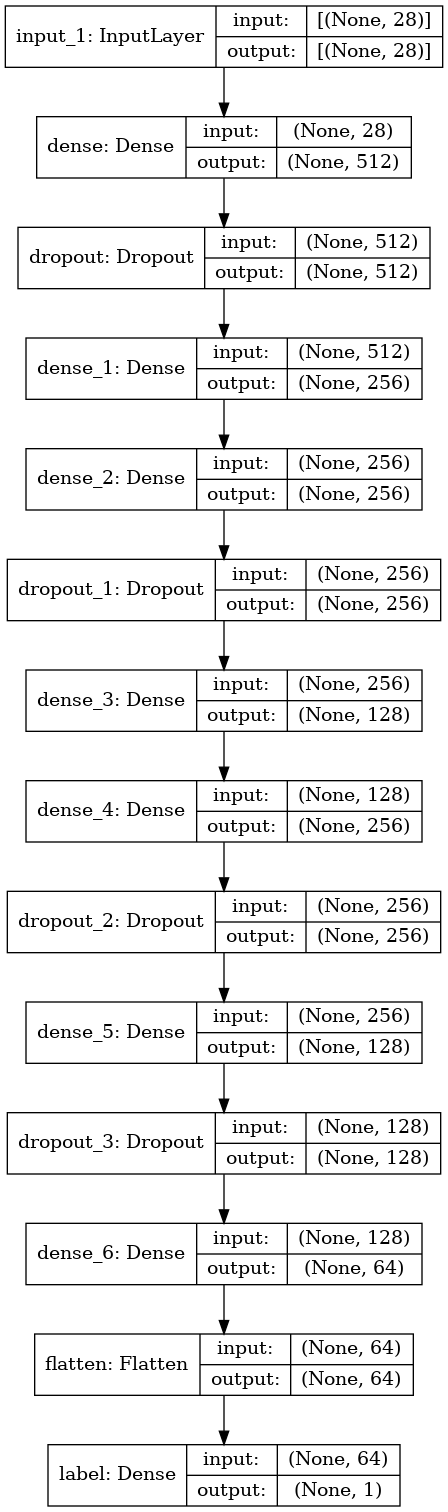

In [21]:
keras.utils.plot_model(model, show_shapes=True)

In [22]:
lr = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
              loss="binary_crossentropy", 
              metrics=['accuracy', keras.metrics.AUC()]
             )

In [23]:
history = model.fit(x_train, y_train, 
          epochs=500, 
          batch_size=1000, 
          validation_data=(x_test, y_test),
          verbose=1)

2022-06-10 12:19:17.868262: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
24/24 [==============================] - 2s 20ms/step - loss: 0.4689 - accuracy: 0.8103 - auc: 0.6035 - val_loss: 0.3620 - val_accuracy: 0.8320 - val_auc: 0.8428
Epoch 2/500
24/24 [==============================] - 0s 6ms/step - loss: 0.3430 - accuracy: 0.8319 - auc: 0.8367 - val_loss: 0.3268 - val_accuracy: 0.8320 - val_auc: 0.8568
Epoch 3/500
24/24 [==============================] - 0s 5ms/step - loss: 0.3292 - accuracy: 0.8345 - auc: 0.8526 - val_loss: 0.3239 - val_accuracy: 0.8735 - val_auc: 0.8582
Epoch 4/500
24/24 [==============================] - 0s 5ms/step - loss: 0.3248 - accuracy: 0.8765 - auc: 0.8535 - val_loss: 0.3139 - val_accuracy: 0.8756 - val_auc: 0.8618
Epoch 5/500
24/24 [==============================] - 0s 5ms/step - loss: 0.3118 - accuracy: 0.8762 - auc: 0.8589 - val_loss: 0.3100 - val_accuracy: 0.8768 - val_auc: 0.8626
Epoch 6/500
24/24 [==============================] - 0s 6ms/step - loss: 0.3070 - accuracy: 0.8782 - auc: 0.8620 - val_loss: 0.3099 - 

KeyError: 'auc_3'

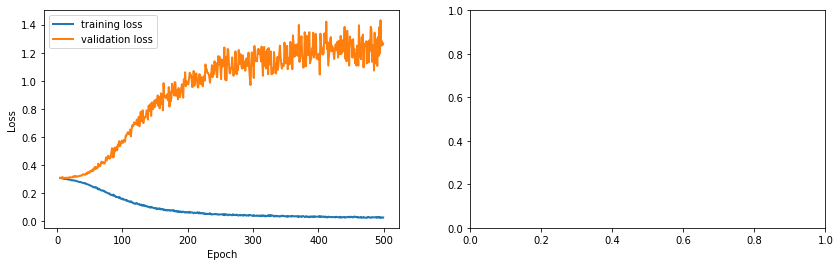

In [24]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc_3"], lw=2, label='training ROC AUC score')
plt.plot(logs.loc[5:,"val_auc_3"], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.0001, # minimium amount of change to count as an improvement
    patience  = 50,     # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.set_weights(weights)

In [ ]:
history = model.fit(x_train, y_train, 
          epochs=500, 
          batch_size=256, 
          validation_data=(x_test, y_test),
          verbose=1,
          # add in our early stopping callback
          callbacks=[early_stopping]
        )

In [ ]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc_3"], lw=2, label='training ROC AUC score')
plt.plot(logs.loc[5:,"val_auc_3"], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.show()

In [ ]:
preds = model.predict(test_norm)

In [ ]:
pred= preds.flatten()

In [ ]:
output = pd.DataFrame({'id': test_data.id, 'label': pred})
output.to_csv('Submission_Team Tubelight_5o18um.csv', index=False)
print(output)

In [ ]:
output['label'].unique()